In [1]:
!nvidia-smi

Mon Jun 17 14:58:22 2019       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 418.40.04    Driver Version: 418.40.04    CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla P40           Off  | 00000000:04:00.0 Off |                  Off |
| N/A   25C    P8     9W / 250W |      0MiB / 24451MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
|   1  Tesla P40           Off  | 00000000:06:00.0 Off |                  Off |
| N/A   28C    P8     9W / 250W |      0MiB / 24451MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
|   2  T

In [2]:
import os
import sys
import numpy as np
import pandas as pd
import warnings
import logging.config
import matplotlib.pyplot as plt

os.environ["OMP_NUM_THREADS"] = "4"
os.environ["OPENBLAS_NUM_THREADS"] = "4"
os.environ["MKL_NUM_THREADS"] = "6"
os.environ["VECLIB_MAXIMUM_THREADS"] = "4"
os.environ["NUMEXPR_NUM_THREADS"] = "6"
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"
warnings.simplefilter('ignore')

%load_ext autoreload
%autoreload 2
%matplotlib inline

In [3]:
sys.path = sys.path[1:]
sys.path.append(os.path.abspath(os.pardir))
sys.path.append(os.path.join(os.path.abspath(os.pardir), 'submodules/tfoptflow/tfoptflow'))
sys.path.append(os.path.join(os.path.abspath(os.pardir), 'submodules/tf_models/research/struct2depth'))

## Data

In [4]:
from odometry.preprocessing.data_parser import (KITTIParser,
                                                TUMParser,
                                                RetailBotParser,
                                                DISCOMANParser)

### TUM

In [5]:
# trajectory_dir = 'tum'
# src_dir = '/Vol1/dbstore/datasets/tum_rgbd_flow/data/rgbd_dataset_freiburg2_coke'
# height, width = 480, 640
# parser = TUMParser(trajectory_dir, src_dir)

### DISCOMAN

In [6]:
# trajectory_dir = 'discoman'
# json_path = '/dbstore/datasets/renderbox/iros2019/dset/output/deprecated/000001/0_traj.json'
# height, width = 120, 160
# parser = DISCOMANParser(trajectory_dir, json_path)

### KITTI

In [7]:
# trajectory_dir = 'kitti'
# trajectory_id = '01'
# height, width = 94, 300
# parser = KITTIParser(trajectory_dir, trajectory_id)

### RetailBot

In [8]:
trajectory_dir = 'retailbot'
src_dir = '/dbstore/datasets/retail_bot/meetingroom_04_rgbd_ir_imu_pose'
height, width = 480, 640
parser = RetailBotParser(trajectory_dir, src_dir)

## Estimators

In [9]:
from odometry.preprocessing.estimators import *


For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
If you depend on functionality not listed there, please file an issue.



### Quaternion2Euler

In [10]:
quaternion2euler_estimator = Quaternion2EulerEstimator(input_col=['q_w', 'q_x', 'q_y', 'q_z'],
                                                       output_col=['euler_x', 'euler_y', 'euler_z'])
quaternion2euler_estimator

Quaternion2EulerEstimator(input_col=['q_w', 'q_x', 'q_y', 'q_z'], output_col=['euler_x', 'euler_y', 'euler_z'])

### Struct2Depth

In [11]:
depth_checkpoint = os.path.abspath('../weights/model-199160')
struct2depth_estimator = Struct2DepthEstimator(input_col='path_to_rgb',
                                               output_col='path_to_depth',
                                               sub_dir='depth',
                                               checkpoint=depth_checkpoint, 
                                               height=height,
                                               width=width)
struct2depth_estimator

Instructions for updating:
Colocations handled automatically by placer.


W0617 14:59:44.914101 47515579485824 deprecation.py:323] From /Vol0/user/a.vorontsova/miniconda3/lib/python3.6/site-packages/tensorflow/python/framework/op_def_library.py:263: colocate_with (from tensorflow.python.framework.ops) is deprecated and will be removed in a future version.
Instructions for updating:
Colocations handled automatically by placer.


Instructions for updating:
Use keras.layers.batch_normalization instead.


W0617 14:59:44.996602 47515579485824 deprecation.py:323] From /Vol0/user/a.vorontsova/odometry/submodules/tf_models/research/struct2depth/nets.py:503: batch_normalization (from tensorflow.python.layers.normalization) is deprecated and will be removed in a future version.
Instructions for updating:
Use keras.layers.batch_normalization instead.
W0617 14:59:47.165472 47515579485824 util.py:204] Shape mismatch, will not restore egomotion_prediction/pose_exp_net/pose/cnv6/weights.
W0617 14:59:47.166253 47515579485824 util.py:206] The following variables in the checkpoint were not loaded:


Instructions for updating:
Use standard file APIs to check for files with this prefix.


W0617 14:59:48.147943 47515579485824 deprecation.py:323] From /Vol0/user/a.vorontsova/miniconda3/lib/python3.6/site-packages/tensorflow/python/training/saver.py:1266: checkpoint_exists (from tensorflow.python.training.checkpoint_management) is deprecated and will be removed in a future version.
Instructions for updating:
Use standard file APIs to check for files with this prefix.


INFO:tensorflow:Restoring parameters from /Vol0/user/a.vorontsova/odometry/weights/model-199160


I0617 14:59:48.149921 47515579485824 saver.py:1270] Restoring parameters from /Vol0/user/a.vorontsova/odometry/weights/model-199160


Struct2DepthEstimator(dir=depth, input_col=path_to_rgb, output_col=path_to_depth, checkpoint=/Vol0/user/a.vorontsova/odometry/weights/model-199160)

### Global2Relative

In [12]:
cols = ['euler_x', 'euler_y', 'euler_z', 't_x', 't_y', 't_z']
input_col = cols + [col + '_next' for col in cols]
output_col = cols
global2relative_estimator = Global2RelativeEstimator(input_col=input_col, output_col=output_col)
global2relative_estimator

Global2RelativeEstimator(input_col=['euler_x', 'euler_y', 'euler_z', 't_x', 't_y', 't_z', 'euler_x_next', 'euler_y_next', 'euler_z_next', 't_x_next', 't_y_next', 't_z_next'], output_col=['euler_x', 'euler_y', 'euler_z', 't_x', 't_y', 't_z'])

### PWC-Net

In [13]:
optical_flow_checkpoint = '/Vol0/user/f.konokhov/tfoptflow/tfoptflow/tmp/pwcnet.ckpt-84000'
#optical_flow_checkpoint = os.path.abspath(../weights/pwcnet.ckpt-595000')  # official weights
pwcnet_estimator = PWCNetEstimator(input_col=['path_to_rgb', 'path_to_rgb_next'],
                                   output_col='path_to_optical_flow',
                                   sub_dir='optical_flow',
                                   checkpoint=optical_flow_checkpoint,
                                   height=height,
                                   width=width)
pwcnet_estimator

Building model...
Instructions for updating:
Use keras.layers.conv2d instead.


W0617 15:00:16.166464 47515579485824 deprecation.py:323] From /Vol0/user/a.vorontsova/odometry/submodules/tfoptflow/tfoptflow/model_pwcnet.py:1173: conv2d (from tensorflow.python.layers.convolutional) is deprecated and will be removed in a future version.
Instructions for updating:
Use keras.layers.conv2d instead.


Instructions for updating:
Use keras.layers.conv2d_transpose instead.


W0617 15:00:17.481612 47515579485824 deprecation.py:323] From /Vol0/user/a.vorontsova/odometry/submodules/tfoptflow/tfoptflow/model_pwcnet.py:1300: conv2d_transpose (from tensorflow.python.layers.convolutional) is deprecated and will be removed in a future version.
Instructions for updating:
Use keras.layers.conv2d_transpose instead.


... model built.
Loading model checkpoint /Vol0/user/f.konokhov/tfoptflow/tfoptflow/tmp/pwcnet.ckpt-84000 for eval or testing...

INFO:tensorflow:Restoring parameters from /Vol0/user/f.konokhov/tfoptflow/tfoptflow/tmp/pwcnet.ckpt-84000


I0617 15:00:21.748888 47515579485824 saver.py:1270] Restoring parameters from /Vol0/user/f.konokhov/tfoptflow/tfoptflow/tmp/pwcnet.ckpt-84000


... model loaded


PWCNetEstimator(dir=optical_flow, input_col=['path_to_rgb', 'path_to_rgb_next'], output_col=path_to_optical_flow, checkpoint=/Vol0/user/f.konokhov/tfoptflow/tfoptflow/tmp/pwcnet.ckpt-84000)

In [14]:
single_frame_estimators = [quaternion2euler_estimator, struct2depth_estimator]
pair_frames_estimators = [global2relative_estimator, pwcnet_estimator]

## Prepare trajectory (ex-Builder)

In [15]:
from odometry.preprocessing.prepare_trajectory import prepare_trajectory

df = prepare_trajectory(trajectory_dir, 
                        parser=parser, 
                        single_frame_estimators=single_frame_estimators,
                        pair_frames_estimators=pair_frames_estimators,
                        stride=1)

PWCNet: 100%|██████████| 5175/5175 [05:43<00:00, 14.03it/s]


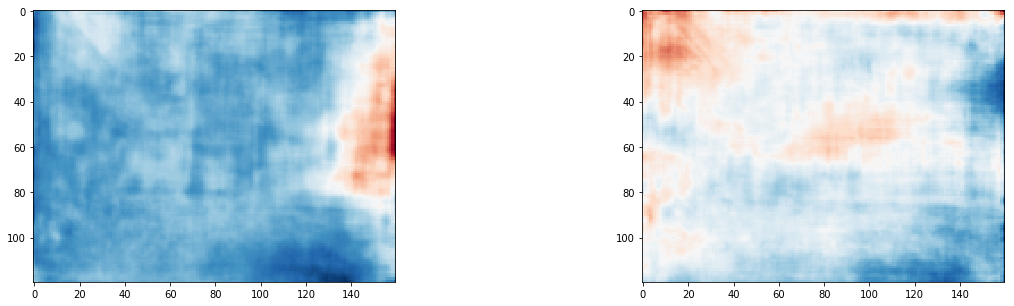

In [16]:
flow = np.load(os.path.join(trajectory_dir, df.path_to_optical_flow.values[0]))

fig, ax = plt.subplots(ncols=2, figsize=(20, 5))
ax[0].imshow(flow[..., 0], cmap='RdBu')
ax[1].imshow(flow[..., 1], cmap='RdBu')
plt.show()

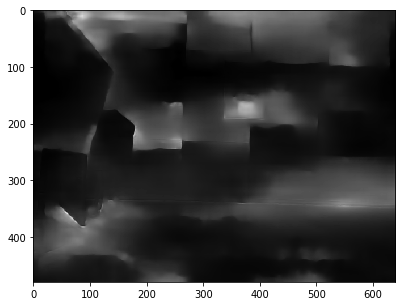

In [17]:
depth = np.load(os.path.join(trajectory_dir, df.path_to_depth.values[0]))

fig, ax = plt.subplots(figsize=(10, 5))
ax.imshow(depth[..., 0], cmap='gray')
plt.show()

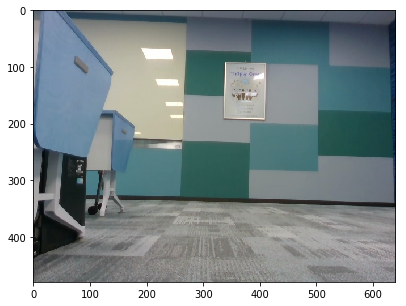

In [19]:
from odometry.utils import load_image

rgb = load_image(os.path.join(trajectory_dir, df.path_to_rgb.values[0]))

fig, ax = plt.subplots(figsize=(10, 5))
ax.imshow(rgb)
plt.show()